In [1]:
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, transform

import cv2
import numpy as np
import os
import pandas as pd
import re

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

READ DATA

In [2]:
#data_train = pd.read_csv("/Users/lethanhtien/Desktop/run/data/train.csv")
data = pd.read_csv("/Users/lethanhtien/Desktop/UIT/MACHINE LEARNING/CS114.O11-FinalProject/data.csv")


CHECK CLASS IMBALANCE

In [3]:
class_counts = data['label'].value_counts()
print(class_counts)

label
3    5126
4    5044
0    3218
1    3176
2    3091
Name: count, dtype: int64


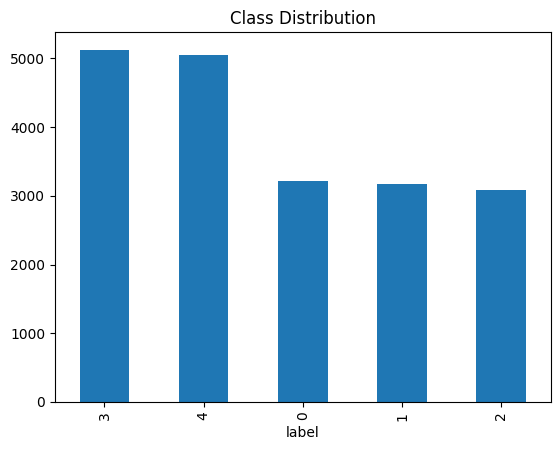

In [4]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cân bằng lớp
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()


In [5]:
total_samples = len(data)
class_ratios = class_counts / total_samples
print(class_ratios)


label
3    0.260799
4    0.256627
0    0.163724
1    0.161587
2    0.157263
Name: count, dtype: float64


SPLIT DATA

In [6]:
# x_train = data_train.drop("label", axis=1)
# y_train = data_train['label']

# x_test = data_test.drop("label", axis=1)
# y_test = data_test['label']

x = data.drop("label", axis=1)
y = data['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [8]:
X_train[0]

array([84, 98, 99, ..., 27, 31, 50])

SCALE DATA

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
# Khởi tạo mô hình MinMaxScaler và fit trên tập huấn luyện
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sử dụng mô hình đã fit để chuẩn hóa tập kiểm tra
X_test_scaled = scaler.transform(X_test)

TRAINING

In [11]:
from sklearn.svm import SVC
# Huấn luyện mô hình SVM với các tham số cụ thể
svm_model = SVC(C=0.1, gamma=0.1, kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = svm_model.predict(X_test_scaled)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.696260493513101


EVALUATE

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Tính precision, recall, và f1-score cho từng lớp
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

class_names = [0,1,2,3,4]

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')

for i in range(len(class_names)):
    print(f"Class {class_names[i]}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print()


Accuracy: 0.696260493513101

Class 0:
  Precision: 0.5740
  Recall: 0.5942
  F1-Score: 0.5839

Class 1:
  Precision: 0.5033
  Recall: 0.4992
  F1-Score: 0.5012

Class 2:
  Precision: 0.4656
  Recall: 0.4773
  F1-Score: 0.4714

Class 3:
  Precision: 0.8481
  Recall: 0.8564
  F1-Score: 0.8523

Class 4:
  Precision: 0.8807
  Recall: 0.8446
  F1-Score: 0.8623



TEST

In [17]:
def test(path):
    # Đường dẫn của tấm ảnh
    image_path = path

    # Mở ảnh bằng Pillow
    img = Image.open(image_path)

    # Chuyển ảnh về ảnh trắng đen
    img = img.convert("L")

    # Chuyển ảnh thành mảng NumPy
    img_array = np.array(img)

    # Resize ảnh về kích thước mong muốn
    resized_img = cv2.resize(img_array, (48, 48))

    flattened_img = resized_img.flatten().reshape(-1, 1)
    # Use MinMaxScaler
    scaler = MinMaxScaler()
    img1 = scaler.fit_transform(flattened_img).T

    y_pred = svm_model.predict(img1)

    return y_pred

In [23]:
test("/Users/lethanhtien/Desktop/UIT/MACHINE LEARNING/CS114.O11-FinalProject/data/happy/ffhq_4.png")

array([4])

SAVE MODEL

In [170]:
from joblib import dump
dump(svm_model, 'svm_model.joblib')

['svm_model.joblib']

SHAP

TRAINING

In [81]:
svm_model = svm.SVC(kernel='linear', max_iter=1000,C=10)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


SVM Accuracy: 0.4819639278557114


In [72]:
svm_model = svm.SVC(kernel='linear', max_iter=100, C=0.1, gamma=0.1)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")

Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


SVM Accuracy: 0.39579158316633267


In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Thiết lập các giá trị thử nghiệm cho C, kernel và gamma
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf'],
              'gamma': [0.1, 1, 10]}

# Tạo mô hình SVM
svm_model = SVC()

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Accuracy: 0.5210420841683366


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Khởi tạo mô hình SVM với các tham số đã cho
svm_model = svm.SVC(C=0.1, gamma=0.1, kernel='linear')

# Huấn luyện mô hình trên tập huấn luyện
svm_model.fit(X_train, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = svm_model.predict(X_test)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Sử dụng SHAP để giải thích dự đoán của mô hình SVM
explainer = shap.Explainer(svm_model)
shap_values = explainer.shap_values(X_test)

# In giải thích
shap.summary_plot(shap_values, X_test, feature_names=data.feature_names)


Accuracy: 0.5210420841683366


In [48]:
pip install joblib



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
# Lưu mô hình vào file
import joblib
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
joblib.dump(svm_model, 'svm_model.joblib')

['svm_model.joblib']

In [63]:
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy}")

KNN Accuracy: 0.37374749498997994


In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Thiết lập các giá trị thử nghiệm cho n_neighbors và weights
param_grid = {'n_neighbors': [1, 3, 5, 7,9,11,13,15],
              'weights': ['uniform', 'distance']}

# Tạo mô hình KNN
knn_model = KNeighborsClassifier()

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.39178356713426854
